# O PROBLEMA

Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados do IBOVESPA (Bolsa de Valores) para criar uma série temporal e prever diariamente o fechamento da base.

Para isso, utilize a base de dados contida no site da investing e selecione o período 'diário', com intervalo de tempo que achar adequado.

Você precisará demonstrar para o time de investimentos:

1. O modelo com storytelling, desde a captura do dado até a entrega do modelo;
2. Justificar a técnica utilizada;
3. Atingir uma acurácia adequada (acima de 70%).

Dica: utilize o maior intervalo de tempo possível para atingir maior acurácia no modelo preditivo.

Fonte: https://br.investing.com/indices/bovespa-historical-data

## Importando bibliotecas

In [1123]:
import warnings 
warnings.filterwarnings(action = 'ignore')

In [1124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Importando dados

In [1125]:
df = pd.read_csv('Dados Históricos - Ibovespa.csv')

In [1126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      2478 non-null   object 
 1   Último    2478 non-null   float64
 2   Abertura  2478 non-null   float64
 3   Máxima    2478 non-null   float64
 4   Mínima    2478 non-null   float64
 5   Vol.      2477 non-null   object 
 6   Var%      2478 non-null   object 
dtypes: float64(4), object(3)
memory usage: 135.6+ KB


In [1127]:
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,08.08.2023,119.090,119.378,119.553,117.492,"10,25M","-0,24%"
1,07.08.2023,119.380,119.509,120.104,118.894,"8,73M","-0,11%"
2,04.08.2023,119.508,120.586,121.442,119.215,"15,07M","-0,89%"
3,03.08.2023,120.586,120.859,122.619,120.365,"13,03M","-0,23%"
4,02.08.2023,120.859,121.249,121.252,119.798,"10,57M","-0,32%"


## Tratamento de dados

In [1128]:
#verificando ocorrência de dados nulos
df.isna().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

In [1129]:
df[df['Vol.'].isnull()]

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
1860,10.02.2016,40.377,40.592,40.592,39.96,NaN,"-0,53%"


In [1130]:
df.drop(1860, inplace = True)
df.isna().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64

In [1131]:
#verificando valores duplicados
df.duplicated().sum()

0

In [1132]:
#verificando ocorrência de espaçamentos
espacamento_encontrado = False

for column in df.columns:
    for index, value in df[column].items():
        if isinstance(value, str) and value.isspace():
            print(f'Espaçamento encontrado na coluna "{column}", linha {index}.')
            espacamento_encontrado = True

if not espacamento_encontrado:
    print('Não há espaçamento nos dados.')

Não há espaçamento nos dados.


In [1133]:
#renomeando colunas
df.rename(columns = {
    'Data': 'data', 
    'Último': 'ultimo', 
    'Abertura': 'abertura', 
    'Máxima': 'maxima', 
    'Mínima': 'minima', 
    'Vol.': 'volume', 
    'Var%': 
    'variacao'}, inplace = True)
df.columns

Index(['data', 'ultimo', 'abertura', 'maxima', 'minima', 'volume', 'variacao'], dtype='object')

In [1134]:
#alterando tipo da coluna de data
df['volume'] = df['volume'].str.replace(',', '.')
df['volume'] = df['volume'].str.replace('K', '')
df['volume'] = df['volume'].str.replace('M', '').astype(float)
df['variacao'] = df['variacao'].str.replace(',', '.')
df['variacao'] = df['variacao'].str.replace('%', '').astype(float)
df['data'] = df['data'].str.replace('.', '-')
df['data'] = pd.to_datetime(df['data'], format='%d-%m-%Y')

In [1135]:
df.head(3)

,data,ultimo,abertura,maxima,minima,volume,variacao
0,2023-08-08,119.090,119.378,119.553,117.492,10.25,-0.24
1,2023-08-07,119.380,119.509,120.104,118.894,8.73,-0.11
2,2023-08-04,119.508,120.586,121.442,119.215,15.07,-0.89


In [1136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2477 entries, 0 to 2477
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   data      2477 non-null   datetime64[ns]
 1   ultimo    2477 non-null   float64       
 2   abertura  2477 non-null   float64       
 3   maxima    2477 non-null   float64       
 4   minima    2477 non-null   float64       
 5   volume    2477 non-null   float64       
 6   variacao  2477 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 154.8 KB


In [1137]:
df.set_index('data', inplace = True)
df.head()

,ultimo,abertura,maxima,minima,volume,variacao
data,,,,,,
2023-08-08,119.090,119.378,119.553,117.492,10.25,-0.24
2023-08-07,119.380,119.509,120.104,118.894,8.73,-0.11
2023-08-04,119.508,120.586,121.442,119.215,15.07,-0.89
2023-08-03,120.586,120.859,122.619,120.365,13.03,-0.23
2023-08-02,120.859,121.249,121.252,119.798,10.57,-0.32


In [1138]:
df.describe()

,ultimo,abertura,maxima,minima,volume,variacao
count,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000
mean,81.943688,81.915690,82.714738,81.136689,8.059298,0.049964
std,26.119702,26.118205,26.298771,25.915758,34.122577,1.581637
min,37.497000,37.501000,38.031000,37.046000,1.190000,-14.780000
25%,54.724000,54.719000,55.223000,54.164000,3.480000,-0.810000
50%,81.435000,81.320000,82.742000,80.740000,4.670000,0.060000
75%,106.279000,106.269000,107.210000,105.218000,9.660000,0.930000
max,130.776000,130.776000,131.190000,129.526000,980.070000,13.910000


## Decompondo a série

In [1139]:
from statsmodels.tsa.seasonal import seasonal_decompose #lib para decompor série temporal
from statsmodels.tsa.stattools import acf, pacf #autocorrelação e autocorrelação parcial

In [1140]:
df_fechamento = df['ultimo'].to_frame()

In [1141]:
df_fechamento.sort_index(inplace = True)

In [1142]:
resultados = seasonal_decompose(df_fechamento, period = 7)

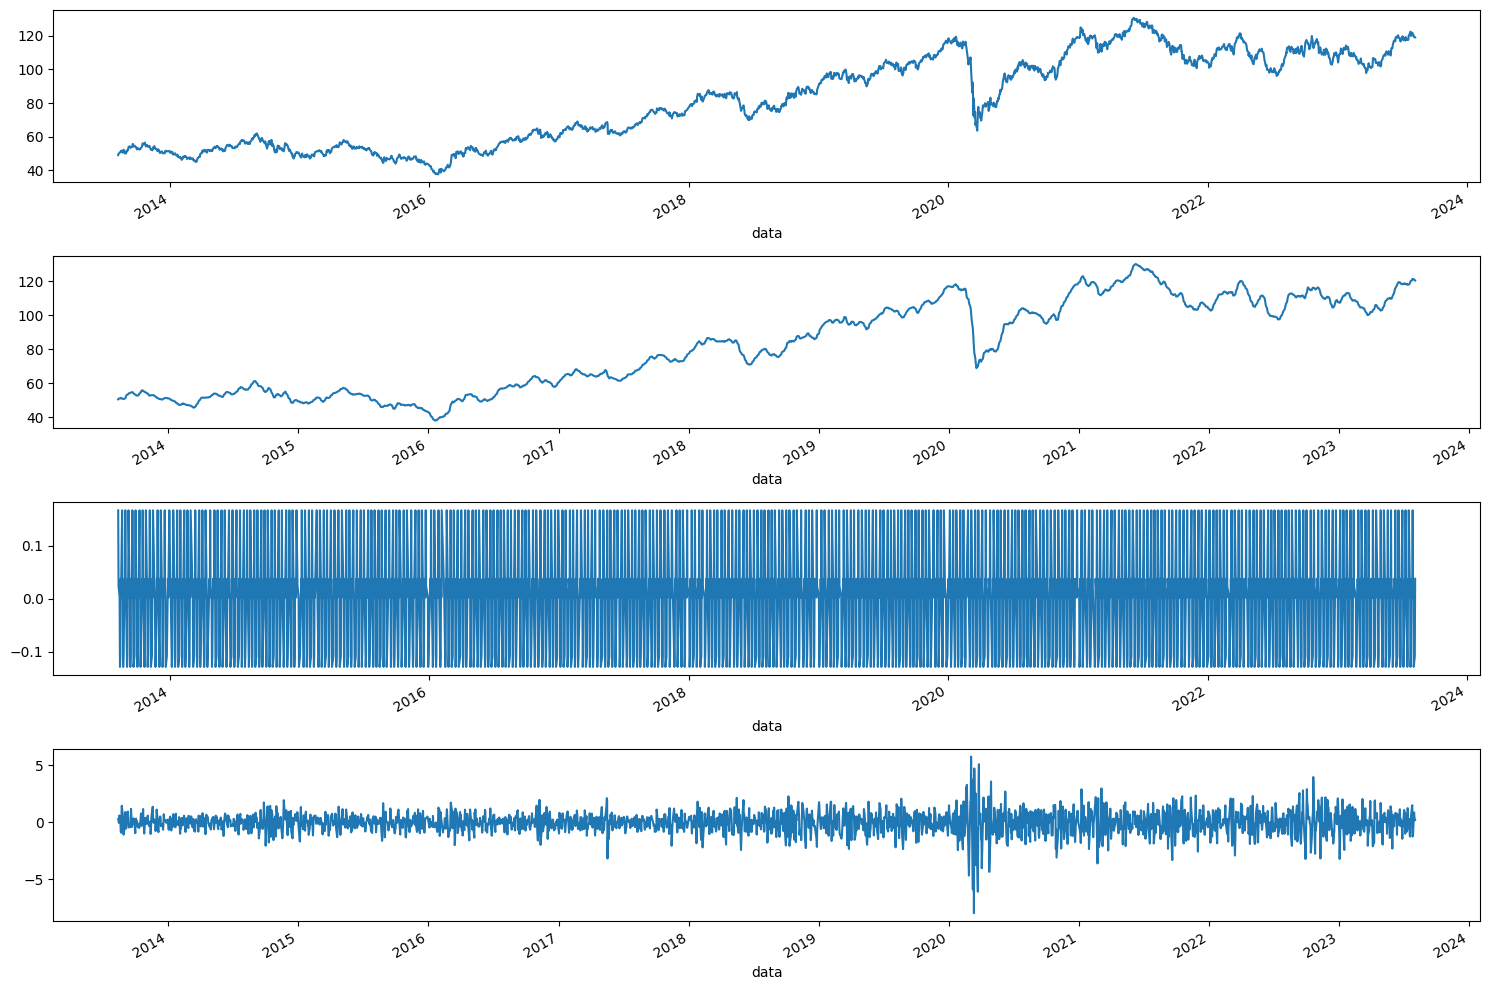

In [1143]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (15, 10))
resultados.observed.plot(ax = ax1)
resultados.trend.plot(ax = ax2)
resultados.seasonal.plot(ax = ax3)
resultados.resid.plot(ax = ax4)
plt.tight_layout()

## Teste estatístico de estacionariedade

### ADF - Augmented Dickey-Fuller

>H0 - Hipótese Nula (não é estacionária)

>H1 - Hipótese Alternativa (rejeita a hipótese nula)

**p-valor <= 0.05 rejeitamos H0 com um nível de confiança de 95%**

In [1144]:
from statsmodels.tsa.stattools import adfuller

In [1145]:
X = df.ultimo.values

result = adfuller(X)

print('Teste ADF')
print(f'Teste estatístico: {result[0]}')
print(f'P-valor: {result[1]}')
print(f'Valores críticos:')

for key, value in result[4].items():
    print(f'\t{key}: {value}')

Teste ADF
Teste estatístico: -1.3644454662057546
P-valor: 0.5991977981222032
Valores críticos:
	1%: -3.4330013210750745
	5%: -2.8627113331035243
	10%: -2.567393547066656


## EDA

### Distribuição das variáveis

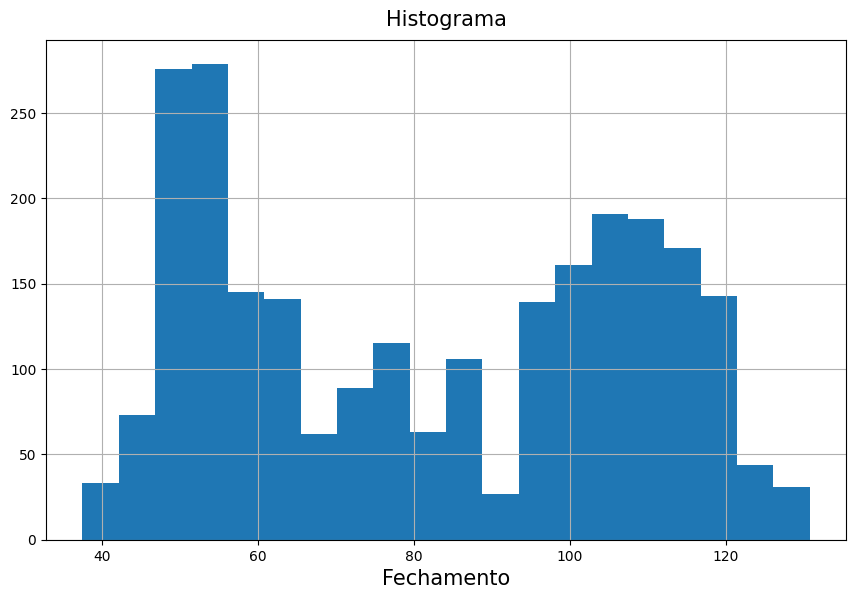

In [1146]:
fig = plt.figure(figsize = (8, 5))
eixo = fig.add_axes([0, 0, 1, 1])

eixo.hist(df['ultimo'], bins=20)
eixo.set_title('Histograma', fontsize = 15, pad = 10)
eixo.set_xlabel('Fechamento', fontsize = 15)
eixo.grid(True)

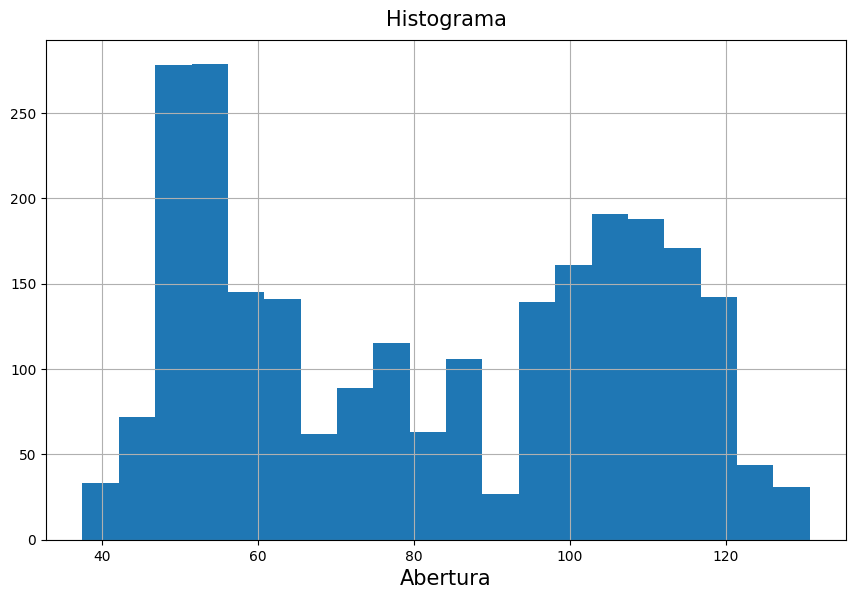

In [1147]:
fig = plt.figure(figsize = (8, 5))
eixo = fig.add_axes([0, 0, 1, 1])

eixo.hist(df['abertura'], bins = 20)
eixo.set_title('Histograma', fontsize = 15, pad = 10)
eixo.set_xlabel('Abertura', fontsize = 15)
eixo.grid(True)

[Text(1, 0, 'Volume')]

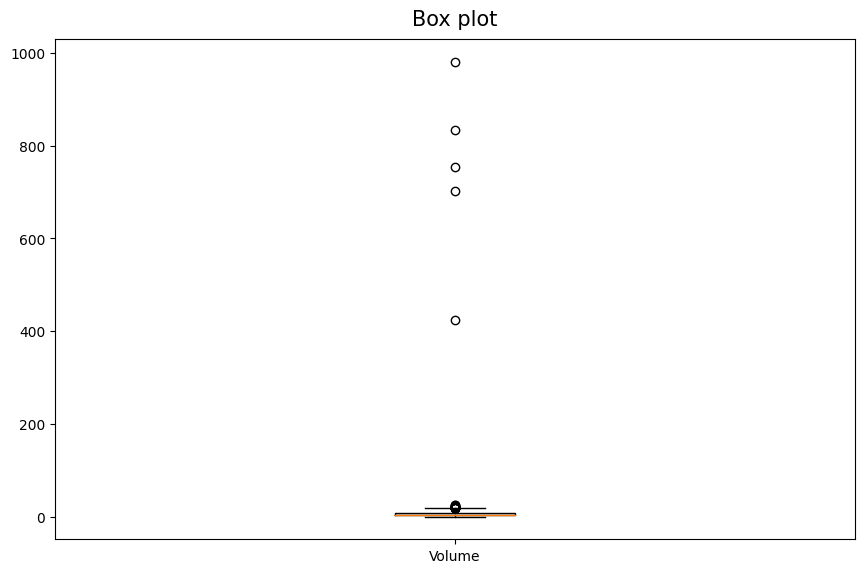

In [1148]:
fig = plt.figure(figsize = (8, 5))
eixo = fig.add_axes([0, 0, 1, 1])

eixo.boxplot(df['volume'])
eixo.set_title('Box plot', fontsize = 15, pad = 10)
eixo.set_xticklabels(['Volume'])

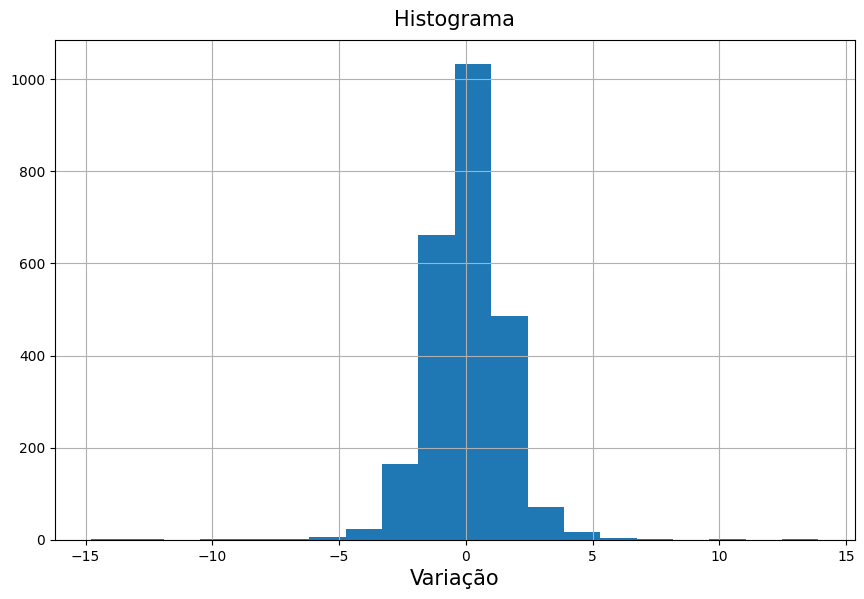

In [1149]:
fig = plt.figure(figsize = (8, 5))
eixo = fig.add_axes([0, 0, 1, 1])

eixo.hist(df['variacao'], bins = 20)
eixo.set_title('Histograma', fontsize = 15, pad = 10)
eixo.set_xlabel('Variação', fontsize = 15)
eixo.grid(True)

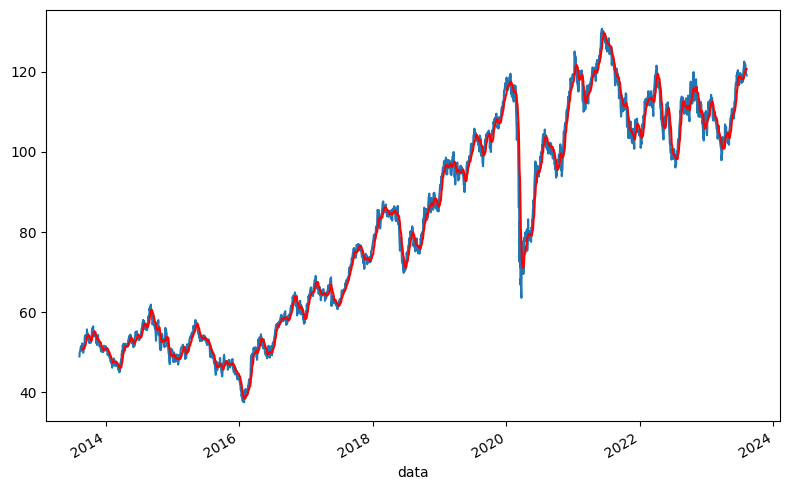

In [1150]:
ma = df_fechamento.rolling(12).mean()

fig, ax = plt.subplots(figsize = (8, 5))
df_fechamento.plot(ax = ax, legend = False)
ma.plot(ax = ax, legend = False, color = 'r')
plt.tight_layout()

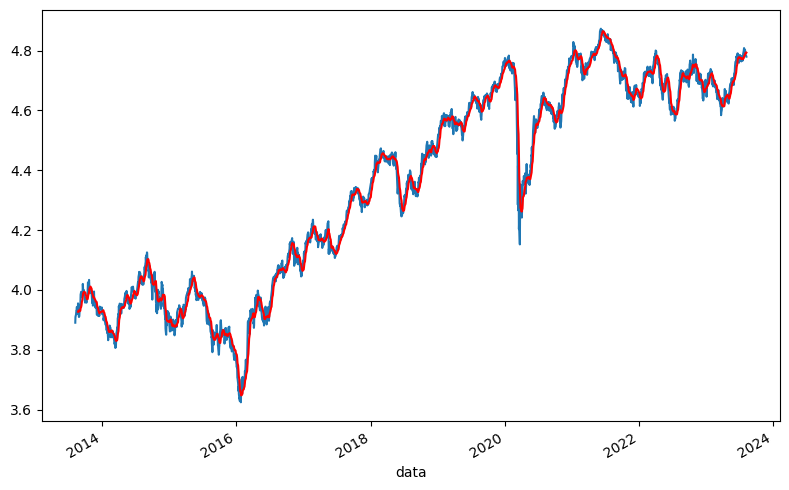

In [1151]:
df_log = np.log(df_fechamento)
ma_log = df_log.rolling(12).mean()

fig, ax = plt.subplots(figsize = (8, 5))
df_log.plot(ax = ax, legend = False)
ma_log.plot(ax = ax, legend = False, color = 'r')
plt.tight_layout()

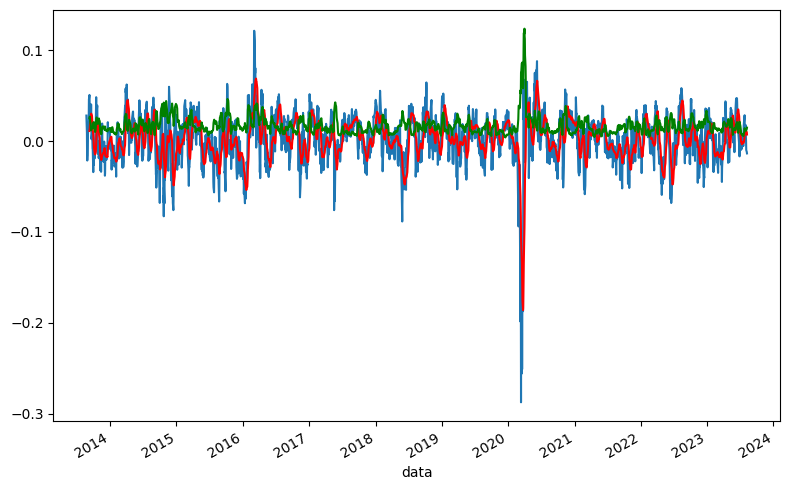

In [1152]:
df_s = (df_log - ma_log).dropna()
ma_s = df_s.rolling(12).mean()
std_s = df_s.rolling(12).std()

f, ax = plt.subplots(figsize = (8, 5))
df_s.plot(ax = ax, legend = False)
ma_s.plot(ax = ax, legend = False, color = 'r')
std_s.plot(ax = ax, legend = False, color = 'g')
plt.tight_layout()

In [1153]:
X_s = df_s.ultimo.values

result_s = adfuller(X_s)

print('Teste ADF')
print(f'Teste estatístico: {result_s[0]}')
print(f'P-valor: {result_s[1]}')
print(f'Valores críticos:')

for key, value in result_s[4].items():
    print(f'\t{key}: {value}')

Teste ADF
Teste estatístico: -12.81503724156076
P-valor: 6.326846328474345e-24
Valores críticos:
	1%: -3.433013198647963
	5%: -2.862716578179761
	10%: -2.5673963396253145


Teste ADF
Teste estatístico: -15.915036403258924
P-valor: 8.042558657510306e-29
Valores críticos:
	1%: -3.4330328659222165
	5%: -2.8627252631029694
	10%: -2.5674009636186508


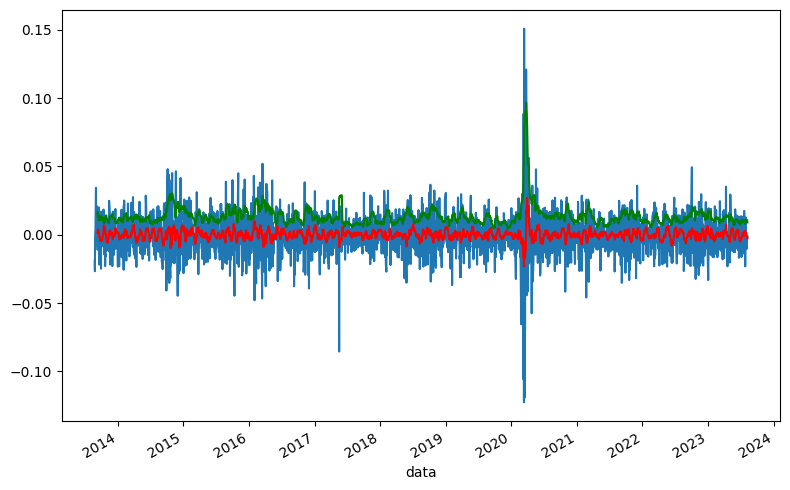

In [1154]:
df_diff = df_s.diff(1)
ma_diff = df_diff.rolling(12).mean()
std_diff = df_diff.rolling(12).std()

f, ax = plt.subplots(figsize = (8, 5))
df_diff.plot(ax = ax, legend = False)
ma_diff.plot(ax = ax, legend = False, color = 'r')
std_diff.plot(ax = ax, legend = False, color = 'g')
plt.tight_layout()

X_diff = df_diff.ultimo.dropna().values

result_diff = adfuller(X_diff)

print('Teste ADF')
print(f'Teste estatístico: {result_diff[0]}')
print(f'P-valor: {result_diff[1]}')
print(f'Valores críticos:')

for key, value in result_diff[4].items():
    print(f'\t{key}: {value}')

### ARIMA - AR (autoregressivo) I (integrado) MA (média móvel)

#### A (x, y, z) -> ACF, PACF

In [1155]:
lag_acf = acf(df_diff.dropna(), nlags = 25) #trabalhando na base mensal
lag_pacf = pacf(df_diff.dropna(), nlags = 25)

### 5% ACF

##### 1.96 / sqrt(N - d) -> N (número de pontos da base), d (número de vezes que diferenciamos a base)

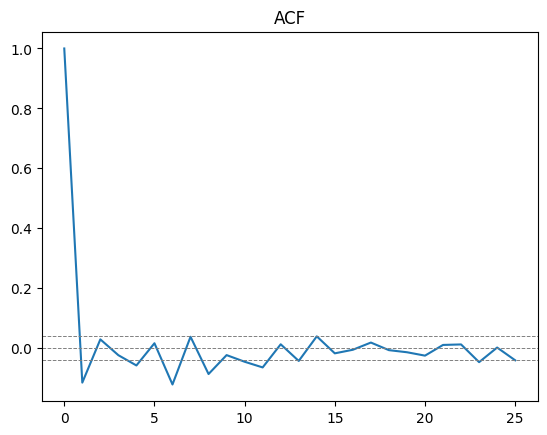

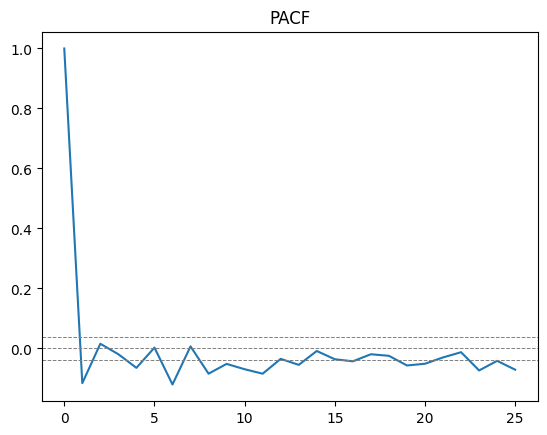

In [1156]:
plt.plot(lag_acf)
plt.axhline(y = -1.96 / (np.sqrt(len(df_diff) -1)), linestyle = '--', color = 'gray', linewidth = 0.7)
plt.axhline(y = 0, linestyle = '--', color = 'gray', linewidth = 0.7)
plt.axhline(y = 1.96 / (np.sqrt(len(df_diff) -1)), linestyle = '--', color = 'gray', linewidth = 0.7)

plt.title('ACF')
plt.show()

plt.plot(lag_pacf)
plt.axhline(y = -1.96 / (np.sqrt(len(df_diff) - 1)), linestyle = '--', color = 'gray', linewidth = 0.7)
plt.axhline(y = 0, linestyle = '--', color = 'gray', linewidth = 0.7)
plt.axhline(y = 1.96 / (np.sqrt(len(df_diff) - 1)), linestyle = '--', color = 'gray', linewidth = 0.7)

plt.title('PACF')
plt.show()

## Modelando

In [1157]:
from statsmodels.tsa.arima.model import ARIMA

In [1158]:
#função para validar a acurácia
def wmape(y_test, y_pred):
    return np.abs(y_test - y_pred).sum() / np.abs(y_test).sum()

### ARIMA

Método estatístico que utiliza autoregressão e médias móveis para previsão de séries temporais. Um modelo linear é construído incluindo um número especificado de termos e os dados são preparados por um nível de diferenciação afim de tornar este estacionário.

Podemos usar um valor 0 para desligar um parâmetro, dessa forma, aquela função em questão não será feita, por exemplo, se no parâmetro d definirmos 0 não será realizada uma diferenciação nos dados. Neste exemplo teríamos um modelo **ARMA**.

---

*   **AR**: *Autoregression* : um modelo que usa a relação dependende entre uma observação e alguns lags.

*   **I**: *Integrated*  : uso de diferenciação nas observações brutas, exemplo: subtração do valor de uma observação com sua observação anterior. O objetivo é transformar a série temporal em estacionária.

*  **MA**: *Moving Average* : um modelo que usa a dependência entre a observação e o erro residual a partir de um modelo de média móvel aplicado a lags.

          residual error = expected − predicted
    
- Isso é diferente de **Moving Average Smoothing.**
- Erros residuais contém estruturas temporais que podem ser modeladas.
- Existem sinais complexos nos erros residuais.
- Um modelo que prever o erro residual pode ser usado para ajustar os próximos erros e melhorar um modelo que aprende com o histórico.




---

O modelo arima contém alguns parâmetros


```
# ARIMA(p,d,q)
```
*   **p:** o número de lags que foram devem ser incluídos no modelo.
*   **d:** o número de vezes que as observações serão diferenciadas.
*   **q:** o tamanho de uma janela de média móvel. Também chamada de ordem de média móvel.

In [1159]:
df_arima = df[(df.index >= '2022-01-01') & (df.index < '2023-08-08')]
df_arima.head()

,ultimo,abertura,maxima,minima,volume,variacao
data,,,,,,
2023-08-07,119.380,119.509,120.104,118.894,8.73,-0.11
2023-08-04,119.508,120.586,121.442,119.215,15.07,-0.89
2023-08-03,120.586,120.859,122.619,120.365,13.03,-0.23
2023-08-02,120.859,121.249,121.252,119.798,10.57,-0.32
2023-08-01,121.248,121.945,121.945,120.154,10.30,-0.57


### Prevendo dados com ARIMA utilizando Walk Forward

Separando os dados de treino e teste

In [1160]:
#a variável X recebe os dados da série
X = df_arima['ultimo'].values

In [1161]:
#separa os dados com 50% dos dados para treino e 50% dos dados para teste
size = int(len(X) * 0.8)

In [1162]:
#separa dados de treino e teste
y_train = X[0:size]
y_test =  X[size:]

In [1163]:
#cria a variável history
history = [x for x in y_train]

In [1164]:
#cria lista de previsões
y_pred = list()

In [1165]:
#cria a função que faz a diferenciação
def difference(dataset, interval = 1):
  diff = list() 
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

#cria função que reverte o valor diferenciado para o original
def inverse_difference(history, previsao, interval = 1):
  return previsao + history[-interval]

In [1166]:
#inicia Walk-Forward
for t in range(len(y_test)):
  
  #difference data
  intervalo = 1
  diff = difference(history, intervalo)

  #cria um modelo ARIMA com os dados de history
  model = ARIMA(diff, order = (1, 0, 0))

  #treina o modelo ARIMA
  model_fit = model.fit()

  #a variável valor_predito recebe o valor previsto pelo modelo
  valor_predito = model_fit.forecast()[0]

  #valor_predito recebe o valor revertido (escala original)
  valor_predito = inverse_difference(history, valor_predito, intervalo)
    
  #adiciona o valor predito na lista de predicões
  y_pred.append(valor_predito)

  #a variável valor_real recebe o valor real do teste
  valor_real = y_test[t]

  #adiciona o valor real a variável history
  history.append(valor_real)

  #imprime valor predito e valor real
  print('Valor predito = %.3f, Valor esperado = %3.f' % (valor_predito, valor_real))

Valor predito = 107.897, Valor esperado = 110
Valor predito = 109.990, Valor esperado = 109
Valor predito = 109.293, Valor esperado = 108
Valor predito = 108.126, Valor esperado = 111
Valor predito = 110.766, Valor esperado = 111
Valor predito = 111.071, Valor esperado = 114


Valor predito = 114.481, Valor esperado = 115
Valor predito = 115.080, Valor esperado = 116
Valor predito = 115.708, Valor esperado = 116
Valor predito = 116.198, Valor esperado = 117
Valor predito = 116.805, Valor esperado = 116
Valor predito = 116.106, Valor esperado = 117
Valor predito = 116.986, Valor esperado = 118
Valor predito = 118.389, Valor esperado = 119
Valor predito = 118.889, Valor esperado = 118
Valor predito = 118.192, Valor esperado = 119
Valor predito = 118.917, Valor esperado = 121
Valor predito = 121.413, Valor esperado = 122
Valor predito = 121.592, Valor esperado = 120
Valor predito = 119.917, Valor esperado = 120
Valor predito = 120.276, Valor esperado = 120
Valor predito = 120.003, Valor esperado = 119
Valor predito = 118.669, Valor esperado = 119
Valor predito = 119.098, Valor esperado = 119
Valor predito = 119.051, Valor esperado = 117
Valor predito = 117.369, Valor esperado = 117
Valor predito = 117.257, Valor esperado = 116
Valor predito = 116.088, Valor esp

In [1167]:
#avaliando os resultados
from numpy import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.264


In [1168]:
print(wmape(y_test, y_pred))

0.008993797861623274


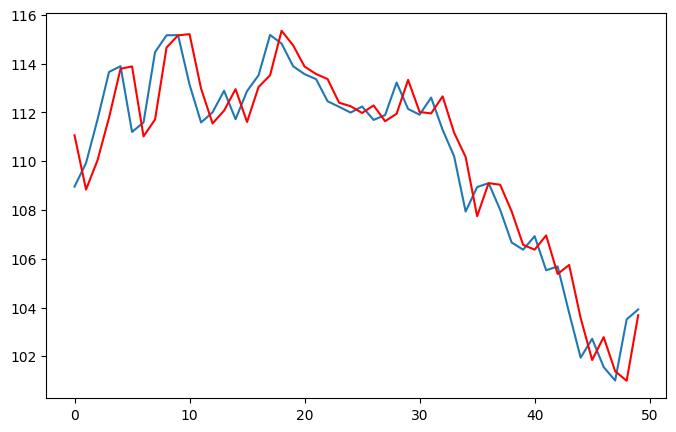

In [1169]:
#plot forecasts against actual outcomes 
plt.figure(figsize = (8, 5))
plt.plot(test)
plt.plot(predictions, color = 'red')
plt.show()

### Analisando Resíduos

      Erro Residual = Valor esperado − Valor Predito

- Erros residuais são erros em previsões de séries temporais.
- Uma análise dos erros pode sugerir melhoras no modelo.
  - Tendências.
  - Sazonalidades.

In [1192]:
#erros residuais 
residos = [y_test[i] - y_pred[i] for i in range(len(y_test))]

In [1193]:
#converte a lista em um dataframe
residos = pd.DataFrame(residos)

In [1194]:
#imprime as 5 primeiras linhas
residos.head()

,0
0,2.022312
1,-0.641195
2,-1.079705
3,2.558908
4,0.312296


In [1195]:
#estatística descritiva
residos.describe()

,0
count,80.000000
mean,-0.026508
std,1.271562
min,-2.699707
25%,-1.076852
50%,-0.038077
75%,0.606930
max,3.273082


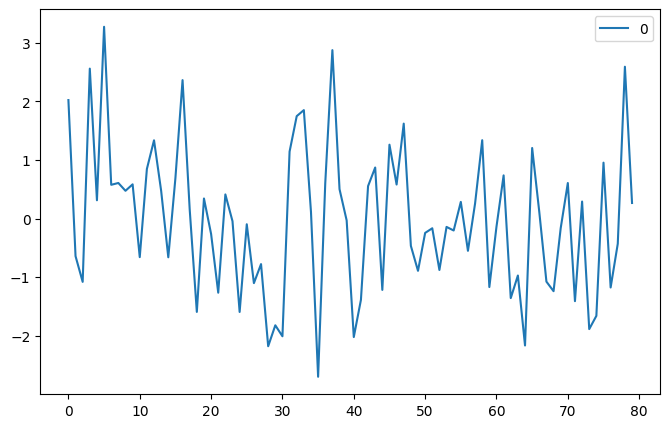

In [1196]:
#plot residuals
residos.plot(figsize=(8,5))
plt.show()

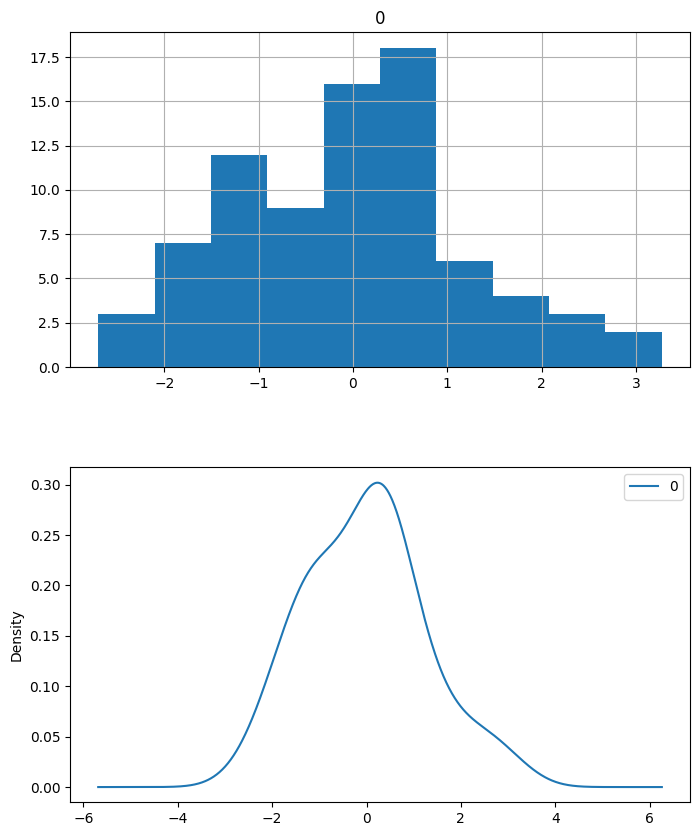

In [1198]:
#plots histograma
plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
residos.hist(ax = plt.gca())

plt.subplot(2,1,2)
residos.plot(kind = 'kde', ax = plt.gca())
plt.show()

In [1176]:
#importa os pacotes de autocorrelação
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

### Prophet

In [1199]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

In [1200]:
df_prophet = df_fechamento.reset_index()
df_prophet.rename(columns = {'data': 'ds', 'ultimo': 'y'}, inplace = True)
df_prophet.tail()

,ds,y
2472,2023-08-02,120.859
2473,2023-08-03,120.586
2474,2023-08-04,119.508
2475,2023-08-07,119.380
2476,2023-08-08,119.090


In [1181]:
treino = df_prophet.loc[df_prophet['ds'] < '2023-01-01'] #dados de treino
valid = df_prophet.loc[(df_prophet['ds'] >= '2023-01-01') & (df_prophet['ds'] < '2023-08-08')] #dados de validação (3 meses), quanto maior o período de predição, maior a largura de banda (maior o erro)
h = valid['ds'].nunique() #datas distintas no intervalo (90 dias)

In [1182]:
h

150

In [1202]:
treino.head()

,ds,y
0,2013-08-08,48.929
1,2013-08-09,49.875
2,2013-08-12,50.299
3,2013-08-13,50.601
4,2013-08-14,50.896


In [1203]:
m = Prophet()
m.fit(treino)

23:24:55 - cmdstanpy - INFO - Chain [1] start processing
23:24:56 - cmdstanpy - INFO - Chain [1] done processing


In [1206]:
future = m.make_future_dataframe(periods = 150)
future.head()

,ds
0,2013-08-08
1,2013-08-09
2,2013-08-12
3,2013-08-13
4,2013-08-14


In [1207]:
valid.head()

,ds,y
2326,2023-01-02,106.376
2327,2023-01-03,104.166
2328,2023-01-04,105.334
2329,2023-01-05,107.641
2330,2023-01-06,108.964


In [1208]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2013-08-08,51.836231,45.534363,58.845282
1,2013-08-09,51.831403,44.705724,59.221021
2,2013-08-12,51.650054,44.499667,58.557104
3,2013-08-13,51.559165,44.480172,59.089255
4,2013-08-14,51.512358,44.680986,58.881290


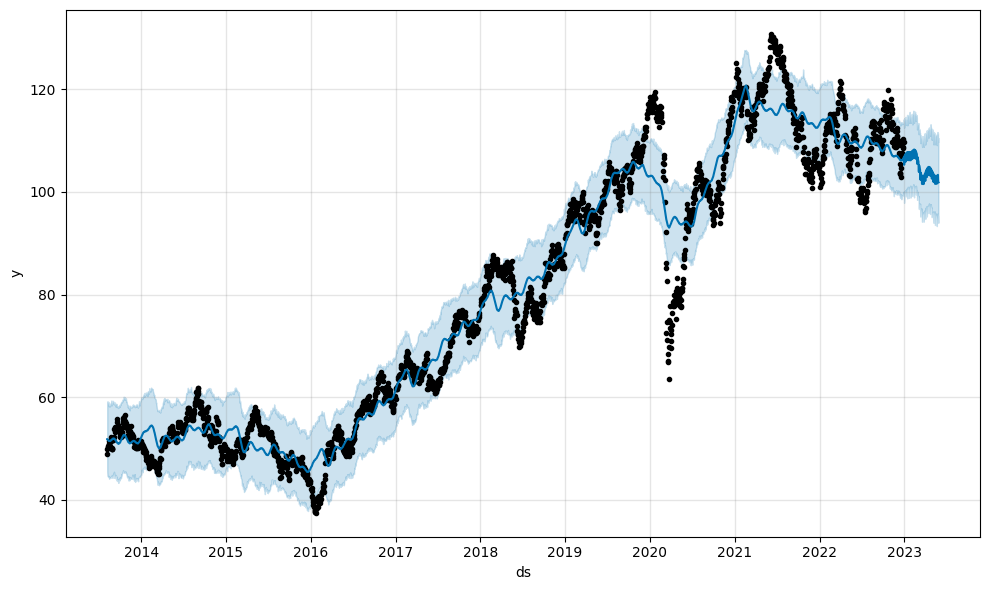

In [1209]:
fig1 = m.plot(forecast)
fig1.show()

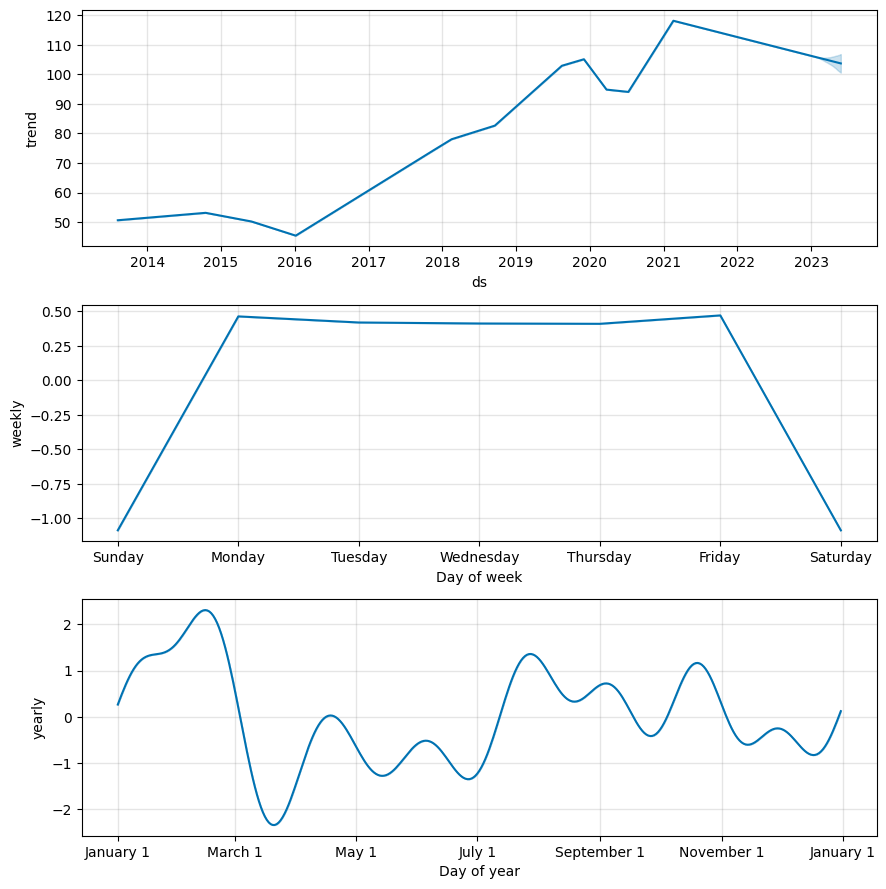

In [1210]:
fig2 = m.plot_components(forecast)
fig2.show()

In [1211]:
plot_plotly(m, forecast)

In [1212]:
plot_components_plotly(m, forecast)